In [2]:
!conda install fastbook

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - fastbook

Current channels:

  - https://repo.anaconda.com/pkgs/main/linux-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/linux-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




In [1]:
!pip install -Uqq fastbook
import fastbook
from fastai.vision.all import *
from fastai.text.all import *
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import List, Dict, Mapping, Iterable, Optional
import torchvision.transforms as T
import pickle 

In [5]:
## DATA ##

In [31]:
root_dir = Path('.')

In [32]:
def get_image_files_train_valid(*args, **kwargs):
  return get_image_files(root_dir/'data_full'/'train') + get_image_files(root_dir/'data_full'/'valid')

In [33]:
metadata = pd.read_csv(root_dir/'data.csv', index_col=0)

In [34]:
def get_y(path): # Gets geocell!
  p = str(path).rstrip(".jpg")
  if p.endswith(" (1)"): p = p[:-4]
  idx = int(re.search(r'(\d*)$', p).group(1))
  return metadata.geocell[idx]

In [35]:
def splitter(paths, small_set=False):
  train_idx = []
  valid_idx = []
  for i, p in enumerate(paths):
    # if small_set and get_y(p) not in small_set_labels:
    #   continue
    if p.parent.name == 'valid': valid_idx.append(i)
    else: train_idx.append(i)
  return train_idx, valid_idx

In [36]:
def get_dls(bs, size, min_scale):
  item_tfms = [] if size == 224 else [Resize(448)]
  normalize_tfm = Normalize.from_stats(*imagenet_stats)
  block = DataBlock(
      get_items=get_image_files_train_valid,
      get_y=get_y,
      blocks=(ImageBlock, CategoryBlock),
      splitter=splitter,
      item_tfms=item_tfms,
      batch_tfms=[
        *aug_transforms(min_scale=min_scale),
        normalize_tfm,
      ]
  )
  im_path = Path()
  return block.dataloaders(im_path, bs=bs)

In [37]:
## MODEL ##

In [38]:
def get_model(dls, arch, dropout_amt):
  arch_to_feats = {resnet34: 512, resnet50: 2048, resnet101: 2048, resnet152: 2048}
  return nn.Sequential(
      create_body(arch, cut=-2),
      create_head(arch_to_feats[arch], len(dls.vocab), lin_ftrs=[512], ps=dropout_amt),
  )

In [39]:
## TRAIN ## 

In [40]:
dls = get_dls(bs=32, size=448, min_scale=1.0)

In [41]:
len(dls.vocab), dls.vocab

(275,
 [0, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 162, 163, 164, 166, 167, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 227, 229, 230, 231, 

In [2]:
model = get_model(dls, resnet101, dropout_amt=0.)

NameError: name 'dls' is not defined

SuggestedLRs(lr_min=0.0001258925418369472, lr_steep=0.00017782794020604342)

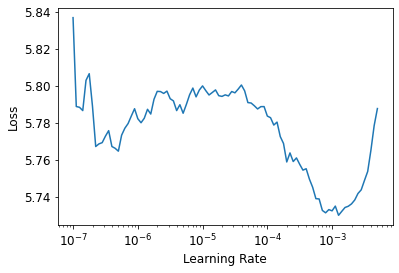

In [45]:
learn = Learner(dls, model, CrossEntropyLossFlat(), metrics=accuracy)
learn.freeze()
learn.lr_find(end_lr=1e-2)

In [46]:
learn.fit_one_cycle(10, 1.5e-4)

epoch,train_loss,valid_loss,accuracy,time
0,4.405766,4.343783,0.096631,11:21
1,3.916919,3.972760,0.128979,11:20
2,3.489909,3.566770,0.168229,11:15
3,3.248825,3.311418,0.201401,11:07
4,2.934359,3.152140,0.221902,11:17
5,2.637678,2.988223,0.248377,11:08
6,2.265900,2.859009,0.267642,11:10
7,1.956514,2.793041,0.284125,11:16
8,1.681520,2.786298,0.282477,11:12
9,1.587657,2.787435,0.280828,11:11


In [47]:
torch.save(learn.model.state_dict, root_dir/"state_dict_geocell_resnet101_448_frozen_5_30")